In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
data = pd.read_csv('train.csv')
data.head(4)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...


In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
data['content'] = data.Title + ' ' + data.Description
labels = data["Class Index"]

In [ ]:
test['content'] = test.Title + ' ' + test.Description
test_labels = test['Class Index']

In [ ]:
train = data.copy()

In [ ]:
train['Class Index'].unique()

array([3, 4, 2, 1])

In [ ]:
train['Class Index'] = train['Class Index'].astype('str')

In [ ]:
test['Class Index'] = test['Class Index'].astype('str')

In [ ]:
for i in list(train['Class Index'].unique()):
    train[i] = train['Class Index'].apply(lambda x: 1 if i in x else 0)
    test[i] = test['Class Index'].apply(lambda x: 1 if i in x else 0)

In [ ]:
train

,Class Index,Title,Description,content,3,4,2,1
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...,1,0,0,0
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...,1,0,0,0
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...,1,0,0,0
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...,1,0,0,0
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new...",1,0,0,0
...,...,...,...,...,...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,Pakistan's Musharraf Says Won't Quit as Army C...,0,0,0,1
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,Renteria signing a top-shelf deal Red Sox gene...,0,0,1,0
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,Saban not going to Dolphins yet The Miami Dolp...,0,0,1,0
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,Today's NFL games PITTSBURGH at NY GIANTS Time...,0,0,1,0


In [ ]:
train.drop(['Description', 'Title', 'Class Index'], axis=1, inplace=True)
test.drop(['Description', 'Title', 'Class Index'], axis=1, inplace=True)

In [ ]:
train

,content,3,4,2,1
0,Wall St. Bears Claw Back Into the Black (Reute...,1,0,0,0
1,Carlyle Looks Toward Commercial Aerospace (Reu...,1,0,0,0
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,1,0,0,0
3,Iraq Halts Oil Exports from Main Southern Pipe...,1,0,0,0
4,"Oil prices soar to all-time record, posing new...",1,0,0,0
...,...,...,...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0,0,0,1
119996,Renteria signing a top-shelf deal Red Sox gene...,0,0,1,0
119997,Saban not going to Dolphins yet The Miami Dolp...,0,0,1,0
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,0,0,1,0


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [ ]:
target_cols = [col for col in train.columns if col not in ['content']]
target_cols

['3', '4', '2', '1']

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.content
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('roberta-base')
        self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768,4)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device);

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%1000 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Эксперимент 1

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.676325798034668
Epoch: 0, Loss:  0.1718769669532776
Epoch: 0, Loss:  0.0882088840007782
Epoch: 0, Loss:  0.09670786559581757
Epoch: 0, Loss:  0.06402631103992462
Epoch: 0, Loss:  0.21325621008872986
Epoch: 0, Loss:  0.040192846208810806
Epoch: 0, Loss:  0.08087514340877533
Epoch: 0, Loss:  0.13702532649040222
Epoch: 0, Loss:  0.12116380035877228
Epoch: 0, Loss:  0.02783135697245598
Epoch: 0, Loss:  0.1337859183549881
Epoch: 0, Loss:  0.06632158160209656
Epoch: 0, Loss:  0.07331570237874985
Epoch: 0, Loss:  0.09163960814476013
Epoch: 0, Loss:  0.12168523669242859
Epoch: 0, Loss:  0.0326395183801651
Epoch: 0, Loss:  0.051546379923820496
Epoch: 0, Loss:  0.03226567804813385
Epoch: 0, Loss:  0.034065596759319305
Epoch: 0, Loss:  0.04375382512807846
Epoch: 0, Loss:  0.06908103823661804
Epoch: 0, Loss:  0.1577828973531723
Epoch: 0, Loss:  0.1780417412519455
Epoch: 0, Loss:  0.11152803897857666
Epoch: 0, Loss:  0.017951656132936478
Epoch: 0, Loss:  0.10185084491968155
Epoch

Эксперимент 2

In [ ]:
# MAX_LEN = 200
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.6964375972747803
Epoch: 0, Loss:  0.13764190673828125
Epoch: 0, Loss:  0.08603700250387192
Epoch: 0, Loss:  0.11079826951026917
Epoch: 0, Loss:  0.035268619656562805
Epoch: 0, Loss:  0.04853198677301407
Epoch: 0, Loss:  0.07911421358585358
Epoch: 0, Loss:  0.08329274505376816
Epoch: 1, Loss:  0.08076965063810349
Epoch: 1, Loss:  0.03467995673418045
Epoch: 1, Loss:  0.0623503103852272
Epoch: 1, Loss:  0.1952342391014099
Epoch: 1, Loss:  0.07857228815555573
Epoch: 1, Loss:  0.03943781554698944
Epoch: 1, Loss:  0.09596486389636993
Epoch: 1, Loss:  0.0959281325340271
Epoch: 2, Loss:  0.048618488013744354
Epoch: 2, Loss:  0.06745748221874237
Epoch: 2, Loss:  0.022285493090748787
Epoch: 2, Loss:  0.12372030317783356
Epoch: 2, Loss:  0.00981954112648964
Epoch: 2, Loss:  0.04114401713013649
Epoch: 2, Loss:  0.05721922218799591
Epoch: 2, Loss:  0.115190789103508


Эксперимент 3

In [ ]:
# MAX_LEN = 100
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.6979095935821533
Epoch: 0, Loss:  0.19138464331626892
Epoch: 0, Loss:  0.10449229180812836
Epoch: 0, Loss:  0.036112360656261444
Epoch: 1, Loss:  0.08465225249528885
Epoch: 1, Loss:  0.027439843863248825
Epoch: 1, Loss:  0.04487670212984085
Epoch: 1, Loss:  0.033968281000852585
Epoch: 2, Loss:  0.07056678831577301
Epoch: 2, Loss:  0.05771073326468468
Epoch: 2, Loss:  0.06510160863399506
Epoch: 2, Loss:  0.053486574441194534


Эксперимент 4

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 16
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.6945646405220032
Epoch: 0, Loss:  0.18752729892730713
Epoch: 0, Loss:  0.1177862286567688
Epoch: 0, Loss:  0.24569256603717804
Epoch: 0, Loss:  0.1087549477815628
Epoch: 0, Loss:  0.1276777684688568
Epoch: 0, Loss:  0.0906381607055664
Epoch: 0, Loss:  0.047380127012729645
Epoch: 1, Loss:  0.038473960012197495
Epoch: 1, Loss:  0.014007090590894222
Epoch: 1, Loss:  0.02128012478351593
Epoch: 1, Loss:  0.26837074756622314
Epoch: 1, Loss:  0.019267825409770012
Epoch: 1, Loss:  0.07261234521865845
Epoch: 1, Loss:  0.011358823627233505
Epoch: 1, Loss:  0.17559729516506195
Epoch: 2, Loss:  0.02126999944448471
Epoch: 2, Loss:  0.2416827380657196
Epoch: 2, Loss:  0.1192154735326767
Epoch: 2, Loss:  0.01416099164634943
Epoch: 2, Loss:  0.016801772639155388
Epoch: 2, Loss:  0.03455238416790962
Epoch: 2, Loss:  0.2461717277765274
Epoch: 2, Loss:  0.010653570294380188


Эксперимент 5

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 3
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.7210969924926758
Epoch: 0, Loss:  0.09620275348424911
Epoch: 1, Loss:  0.06127020716667175
Epoch: 1, Loss:  0.0724937841296196
Epoch: 2, Loss:  0.09273102134466171
Epoch: 2, Loss:  0.060465388000011444


Эксперимент 6

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 5
# LEARNING_RATE = 2e-5
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.6786757707595825
Epoch: 0, Loss:  0.0940885990858078
Epoch: 1, Loss:  0.14497269690036774
Epoch: 1, Loss:  0.11684798449277878
Epoch: 2, Loss:  0.07010377198457718
Epoch: 2, Loss:  0.05300711840391159
Epoch: 3, Loss:  0.030746296048164368
Epoch: 3, Loss:  0.047912511974573135
Epoch: 4, Loss:  0.028837475925683975
Epoch: 4, Loss:  0.020963776856660843


Эксперимент 7

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 2
# LEARNING_RATE = 2e-6
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.6933864951133728
Epoch: 0, Loss:  0.15292535722255707
Epoch: 0, Loss:  0.15748770534992218
Epoch: 0, Loss:  0.051290176808834076
Epoch: 1, Loss:  0.0183663722127676
Epoch: 1, Loss:  0.09555250406265259
Epoch: 1, Loss:  0.046785660088062286
Epoch: 1, Loss:  0.07258466631174088


In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 4
# LEARNING_RATE = 2e-6
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.01984761655330658
Epoch: 0, Loss:  0.0759541466832161
Epoch: 0, Loss:  0.041911233216524124


In [ ]:
def test():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

Эксперимент 1

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.949078947368421
F1 Score (Micro) = 0.9513655807831523
F1 Score (Macro) = 0.9514575457524298


Эксперимент 2

In [ ]:
# MAX_LEN = 200
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9471052631578948
F1 Score (Micro) = 0.949105733824303
F1 Score (Macro) = 0.9490218334012003


Эксперимент 3

In [ ]:
# MAX_LEN = 100
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9486842105263158
F1 Score (Micro) = 0.9513335528482055
F1 Score (Macro) = 0.9513112558765793


Эксперимент 4

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 16
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9461842105263157
F1 Score (Micro) = 0.9483314684394129
F1 Score (Macro) = 0.9483058841461188


Эксперимент 5

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9467105263157894
F1 Score (Micro) = 0.9494112229458589
F1 Score (Macro) = 0.9494967911232283


Эксперимент 6

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 5
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9430263157894737
F1 Score (Micro) = 0.9459049878105027
F1 Score (Macro) = 0.9456927068006925


Эксперимент 7

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 2
# LEARNING_RATE = 2e-6
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.94
F1 Score (Micro) = 0.9446348536778275
F1 Score (Macro) = 0.9446257028726492


In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 4
# LEARNING_RATE = 2e-6
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
new_targets = []
for each in targets:
  tar = []
  tar.append(int(each[0] * 3))
  tar.append(int(each[1] * 4))
  tar.append(int(each[2] * 2))
  tar.append(int(each[3] * 1))
  new_targets.append(max(tar))

In [ ]:
# tar = []
# tar.append(int(targets[0][0] * 3))
# tar.append(int(targets[0][1] * 4))
# tar.append(int(targets[0][2] * 2))
# tar.append(int(targets[0][3] * 1))
# max(tar)

In [ ]:
cols = [3, 4, 2, 1]
new_outputs = []
count = 0
for each in outputs:
  count += 1
  if (not each[0] and not each[1] and  not each[2] and  not each[3]):
    i = random.randrange(len(cols))
    new_outputs.append(cols[i])
    continue 
  for i in range(4):
    if(each[i]):
      new_outputs.append(cols[i])
      break

Эксперимент 1

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

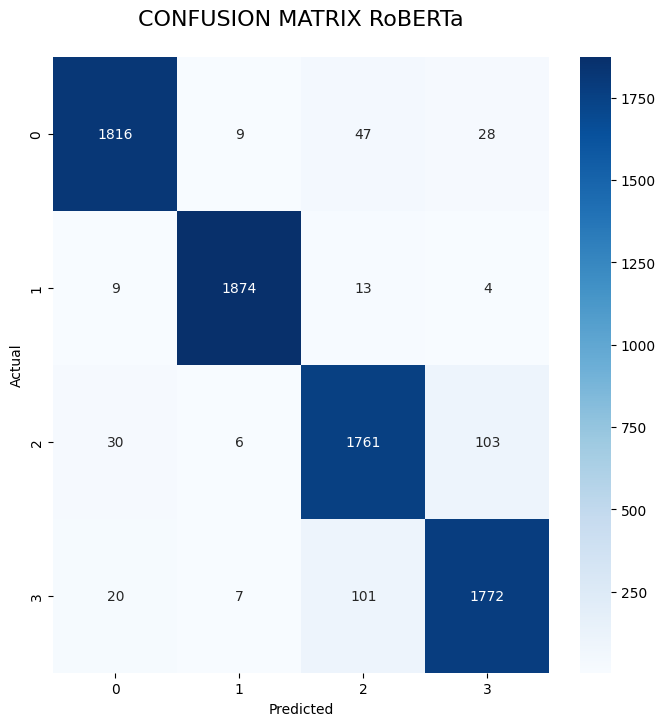

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 2

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

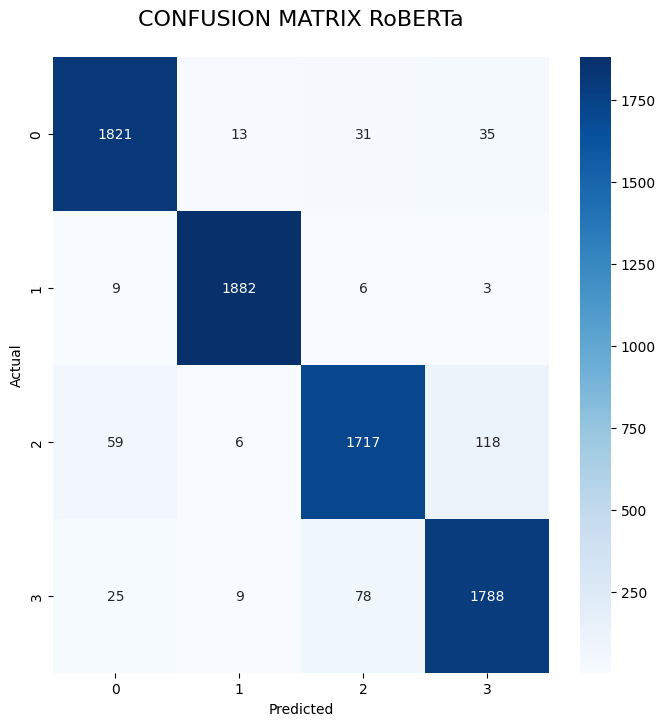

In [ ]:
# MAX_LEN = 200
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 3

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

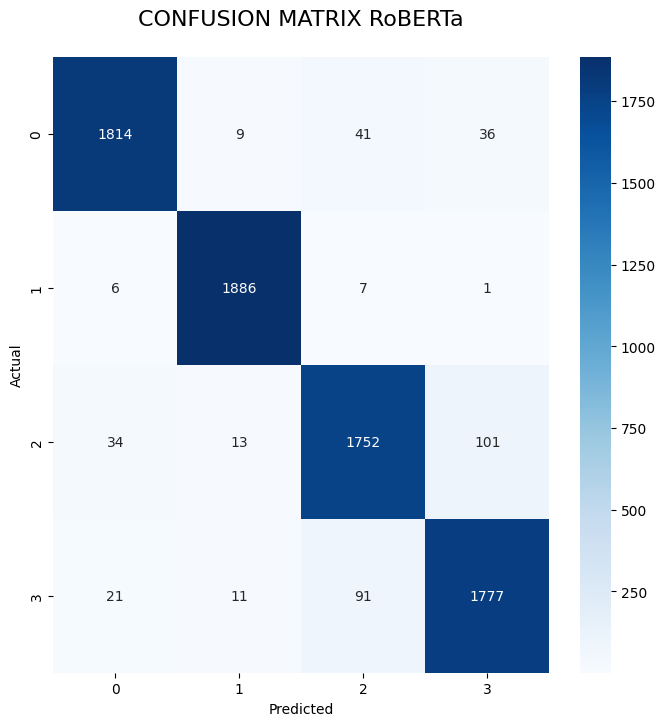

In [ ]:
# MAX_LEN = 100
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 4

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

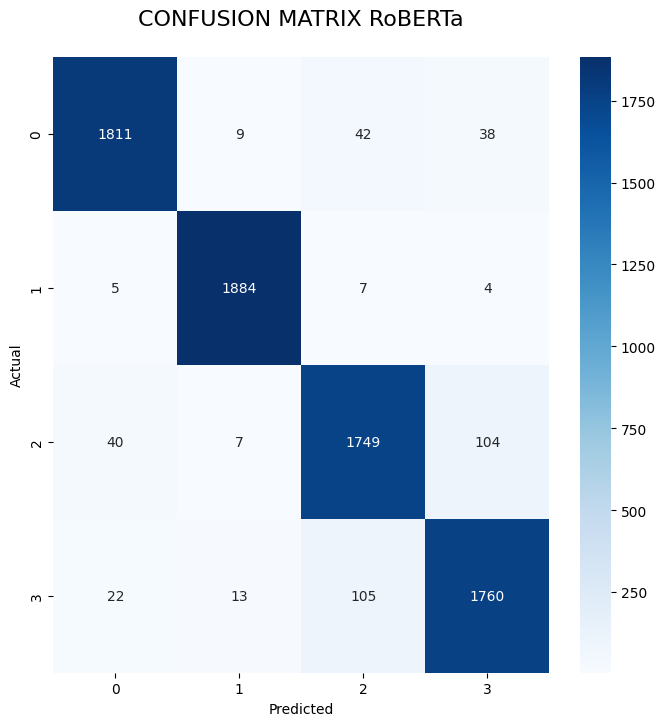

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 16
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 5

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

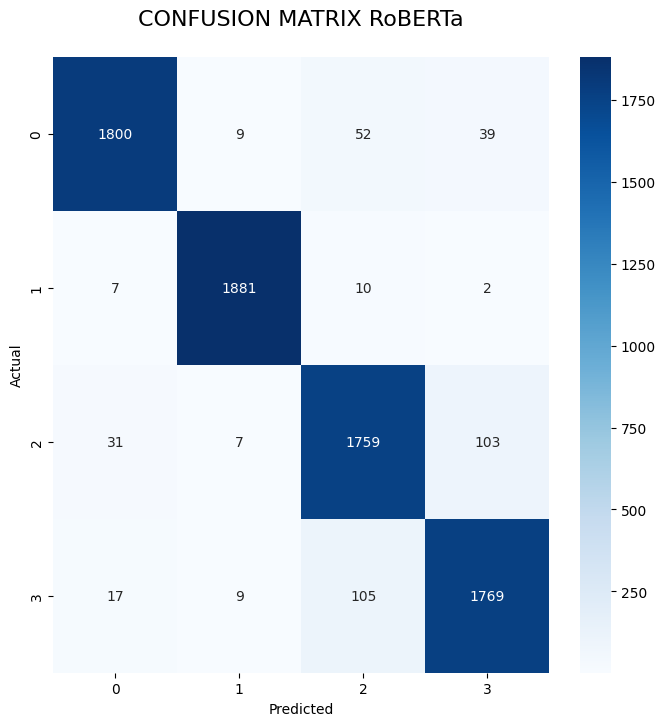

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 3
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 6

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

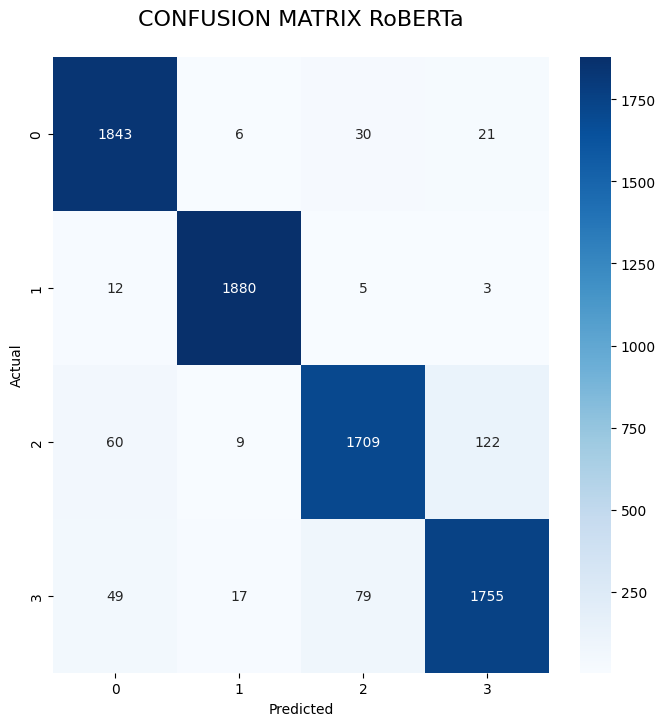

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 64
# EPOCHS = 5
# LEARNING_RATE = 2e-5
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

Эксперимент 7

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

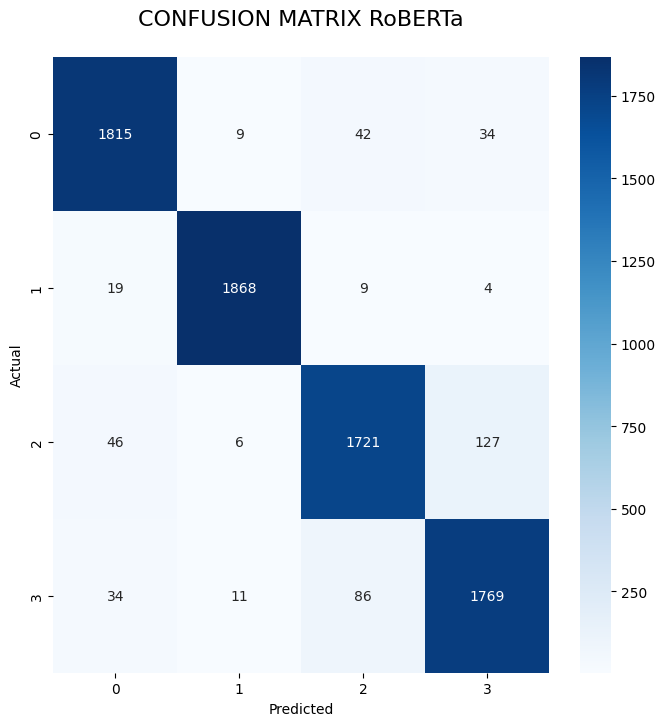

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 2
# LEARNING_RATE = 2e-6
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE =32
# EPOCHS = 4
# LEARNING_RATE = 2e-6
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

In [ ]:
def saveModel():
    path = "./Roberta_AG_128_5_64_2e-5.pth"
    torch.save(model.state_dict(), path)

In [ ]:
saveModel()

Final

In [ ]:
# MAX_LEN = 128
# BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5
outputs, targets = test()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
def test_model_by_train():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
train_outputs, train_targets = test_model_by_train()
train_outputs = np.array(train_outputs) >= 0.5
accuracy = metrics.accuracy_score(train_targets, train_outputs)
f1_score_micro = metrics.f1_score(train_targets, train_outputs, average='micro')
f1_score_macro = metrics.f1_score(train_targets, train_outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
train_outputs, train_targets = test_model_by_train()

In [ ]:
new_targets = []
for each in targets:
  tar = []
  tar.append(int(each[0] * 3))
  tar.append(int(each[1] * 4))
  tar.append(int(each[2] * 2))
  tar.append(int(each[3] * 1))
  new_targets.append(max(tar))

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
clf = LinearSVC(C=0.1, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_outputs, new_targets)
y_pred = clf.predict(test_outputs)
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
clf = LinearSVC(C=0.5, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_outputs, new_targets)
y_pred = clf.predict(test_outputs)
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
clf = LinearSVC(C=1, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(train_outputs, new_targets)
y_pred = clf.predict(test_outputs)
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=16)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(test_labels, y_pred))